# Dependencies

In [1]:
import torch
from torchvision import datasets, transforms, models  # datsets  , transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For VGG16

In [2]:
transform2 = transforms.Compose([
    transforms.Resize((256, 256)),  # Slightly larger resize first
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),  # Gentle crop (reduced from 0.8)
    transforms.RandomHorizontalFlip(p=0.3),  # Reduced probability
    transforms.ColorJitter(brightness=0.1, contrast=0.1),  # Reduced intensity
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

In [ ]:
# Visualize augmented samples
temp_loader = torch.utils.data.DataLoader(dataset_vgg, batch_size=16, shuffle=True)
images, _ = next(iter(temp_loader))
plt.figure(figsize=(12,12))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(images[i].permute(1,2,0).numpy()*0.5+0.5)  # Un-normalize
plt.show()

In [3]:
dataset_vgg=datasets.ImageFolder("/kaggle/input/mepco-tropic-leaf/MepcoTropicLeaf-V1/Database", transform=transform2)

## Splitting the dataset 

In [4]:
indices=list(range(len(dataset_vgg))) # dataset ko numerate karne ke liye
split=int(np.floor(0.70*len(dataset_vgg)))
validation=int(np.floor(0.60*split))

# agar tmre pass 100 samples hai
# toh split=70(ie 70% of the dataset)-> ee use hoga training and validation ke liye; remaining (30)30% used hoga as test set
# tb validation=42 (ie 60% of the dataset)-> ee use hoga for training ke liye; remaining (28)40% used hoga as Validation set
# toh phir training= 42%; validation= 28%; test=30%

print(f"length of train size : {validation}")
print(f"length of validation size : {split-validation}")
print(f"length of test size : {len(dataset_vgg)-split}")

np.random.shuffle(indices) # dataset me randomness laane ke liye

# ab actual splitting
train_indices, validation_indices, test_indices = (
    indices[:validation], # [:5]->0,1,2,3,4
    indices[validation:split],# [1:3]->1,2
    indices[split:],# [2:]-> 2,3,4,5,........
)

train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(validation_indices)
test_sampler = SubsetRandomSampler(test_indices)

# print(list(train_indices))
# print(list(validation_indices))
# print(list(test_indices))

# print(list(train_sampler))
# print(list(validation_sampler))
# print(list(test_sampler))


length of train size : 1585
length of validation size : 1058
length of test size : 1134


## No. of unique features

In [6]:
targets_size = len(dataset_vgg.class_to_idx)# finding the total unique classes and storing it
print(targets_size)
print(list(dataset_vgg.class_to_idx.keys()))
num_classes_list = list(dataset_vgg.class_to_idx.values())# now numerating them
print(num_classes_list)

50
['Asthma Plant.zip', 'Avaram.zip', 'Balloon vine.zip', 'Bellyache bush (Green).zip', 'Benghal dayflower.zip', 'Big Caltrops.zip', 'Black-Honey Shrub.zip', 'Bristly Wild Grape.zip', 'Butterfly Pea.zip', 'Cape Gooseberry.zip', 'Common Wireweed.zip', 'Country Mallow.zip', 'Crown flower.zip', 'Green Chireta.zip', 'Holy Basil.zip', 'Indian CopperLeaf.zip', 'Indian Jujube.zip', 'Indian Sarsaparilla.zip', 'Indian Stinging Nettle.zip', 'Indian Thornapple.zip', 'Indian wormwood.zip', 'Ivy Gourd.zip', 'Kokilaksha.zip', 'Land Caltrops (Bindii).zip', 'Madagascar Periwinkle.zip', 'Madras Pea Pumpkin.zip', 'Malabar Catmint.zip', 'Mexican Mint.zip', 'Mexican Prickly Poppy.zip', 'Mountain Knotgrass.zip', 'Nalta Jute.zip', 'Night blooming Cereus.zip', 'Panicled Foldwing.zip', 'Prickly Chaff Flower.zip', 'Punarnava.zip', 'Purple Fruited Pea Eggplant.zip', 'Purple Tephrosia.zip', 'Rosary Pea.zip', 'Shaggy button weed.zip', 'Small Water Clover.zip', 'Spiderwisp.zip', 'Square Stalked Vine.zip', 'Stinkin

## Loading VGG16

In [7]:
model3 = models.vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Extracting Feature size 

In [8]:
n_features = model3.classifier[0].in_features #vgg16; number of input features in the first fully connected layer
n_features

25088

## Overriding the calculations to GPU if available 

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device) #checking if GPU is available
model3.to(device)

cuda


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Optimizer and criterion for gradient descent 

In [10]:
criterion = nn.CrossEntropyLoss()  # this include softmax + cross entropy loss
# calculates the loss during training, which will be later used by backpropagation to imporove the models accuracy
optimizer = torch.optim.Adam(model3.parameters())
#adam optimiser is used to optimise the models parameters(weights of the model) to minimise the loss and hence increase the accuracy

## Actual training

### Data transform

In [ ]:
# data_transforms = {
#     'train_loader': transforms.Compose([
#         transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), shear=5),
#         transforms.ColorJitter(hue=0.05, saturation=0.05),
#         transforms.RandomHorizontalFlip(),
#         transforms.Grayscale(num_output_channels=1),
#          transforms.RandomApply([transforms.GaussianBlur(kernel_size=7)], p=0.2),
#         transforms.ToTensor(),
#         transforms.Normalize((0.5,), (0.5,)),
#     ]),
#     'validation_loader': transforms.Compose([
#         transforms.ToTensor(),
#         transforms.Normalize((0.5,), (0.5,)),
#     ])
# }

### Dividing the dataset into train, test, validation batches

In [11]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    dataset_vgg, batch_size=batch_size, sampler=train_sampler
)
test_loader = torch.utils.data.DataLoader(
    dataset_vgg, batch_size=batch_size, sampler=test_sampler
)
validation_loader = torch.utils.data.DataLoader(
    dataset_vgg, batch_size=batch_size, sampler=validation_sampler
)

### Gradient Descent

In [12]:
def batch_gd(model, criterion, train_loader, test_loader, epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for e in range(epochs):

        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, targets)
            train_loss.append(loss.item())  # torch to numpy world
            loss.backward()
            optimizer.step()

        train_loss = np.mean(train_loss)
        validation_loss = []

        for inputs, targets in validation_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            output = model(inputs)
            loss = criterion(output, targets)
            validation_loss.append(loss.item())  # torch to numpy world

        validation_loss = np.mean(validation_loss)
        train_losses[e] = train_loss
        dt = datetime.now() - t0
        print(f"Epoch : {e+1}/{epochs} Train_loss:{train_loss:.3f} Duration:{dt}")

    return train_losses

In [13]:
train_losses_vgg = batch_gd(model3, criterion, train_loader, validation_loader, 10)

Epoch : 1/10 Train_loss:7.393 Duration:0:01:01.258250
Epoch : 2/10 Train_loss:3.996 Duration:0:00:59.529109
Epoch : 3/10 Train_loss:3.940 Duration:0:00:59.425396
Epoch : 4/10 Train_loss:3.931 Duration:0:00:59.330118
Epoch : 5/10 Train_loss:3.899 Duration:0:00:59.423049
Epoch : 6/10 Train_loss:3.688 Duration:0:00:59.384010
Epoch : 7/10 Train_loss:3.478 Duration:0:00:59.273470
Epoch : 8/10 Train_loss:3.101 Duration:0:00:59.424601
Epoch : 9/10 Train_loss:2.812 Duration:0:00:59.493968
Epoch : 10/10 Train_loss:2.487 Duration:0:00:59.102832


## Loss Graph 

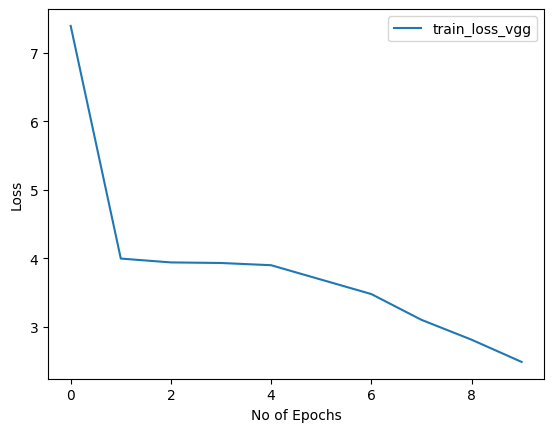

In [14]:
plt.plot(train_losses_vgg , label = 'train_loss_vgg')
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()#validation loss ke liye 

## Accuracy

In [15]:
def accuracy(loader):
    n_correct = 0
    n_total = 0
    model3.cuda()
    for inputs, targets in loader:
        inputs, targets = inputs.cuda(), targets.cuda()
        outputs = model3(inputs)
        #print(outputs)
        _, predictions = torch.max(outputs, 1)
        n_correct += (predictions == targets).sum().item()
        n_total += targets.shape[0]

    acc = n_correct / n_total
    return acc

In [17]:
train_acc = accuracy(train_loader)
test_acc = accuracy(test_loader)
validation_acc = accuracy(validation_loader)

print(
    f"Train Accuracy : {train_acc}\nTest Accuracy : {test_acc}\nValidation Accuracy : {validation_acc}"
)

Train Accuracy : 0.2618296529968454
Test Accuracy : 0.23633156966490299
Validation Accuracy : 0.23251417769376181
